In [1]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
from src.cohort import load_aki_cohort
from src.utils import (
    add_icu_los_days,
    add_dialysis_flag,
    add_early_dopamine_flag,
    add_sofa_score,
    add_sapsii_score,
    add_vasopressor_flags,
    add_mechanical_ventilation_flag,
    add_early_late_dialysis_flags,
    extract_dialysis_timing,              # falls in src.utils vorhanden
    add_dialysis_near_icu_discharge_flag,
    recode_ethnicity,
    add_rrt_persistence_near_discharge,
)

# 1) Load cohort
df_aki = load_aki_cohort()

# 2) Ensure time columns are datetime (super wichtig!)
for c in ["intime", "outtime", "admittime", "dischtime", "deathtime"]:
    if c in df_aki.columns:
        df_aki[c] = df_aki[c].astype("datetime64[ns]")

# 3) Add baseline / outcomes
df_aki = add_icu_los_days(df_aki)

# 4) Dialysis "ever" flag (pragmatic; ICD + MV)
df_aki = add_dialysis_flag(df_aki)

# 5) SOFA + interventions
df_aki = add_sofa_score(df_aki)
df_aki = add_sapsii_score(df_aki)
df_aki = add_mechanical_ventilation_flag(df_aki)

# 6) Vasopressors / dopamine early flags
df_aki = add_vasopressor_flags(df_aki, window_hours=24)
df_aki = add_early_dopamine_flag(df_aki, window_hours=24)

# 7) Ethnicity grouping
df_aki = recode_ethnicity(df_aki)   # sollte eine neue Spalte wie ethnicity_grp erzeugen

# 8) Timing-aware dialysis (nur MV Events)
df_aki = add_early_late_dialysis_flags(
    df_aki,
    window_hours=24,
    include_inputevents=True,
    allow_negative_hours=False
)

# 9) Optional: Dialysis start/end/duration (falls du die Funktion hast)
# df_aki = extract_dialysis_timing(df_aki)

# 10) Dialysis near ICU discharge (last 6h)
df_aki = add_dialysis_near_icu_discharge_flag(
    df_aki,
    hours_before_discharge=6,
    include_inputevents=True
)
df_aki = extract_dialysis_timing(df_aki)
df_aki = add_rrt_persistence_near_discharge(
    df_aki,
    hours_before_discharge=6
) 

# 11) Quick sanity checks
print("Rows:", len(df_aki))


Rows: 10485


In [3]:
import pandas as pd

def intervention_summary(df, cols):
    out = []
    n = len(df)
    for c in cols:
        if c not in df.columns:
            continue
        s = df[c]
        # robust: falls bool/float/NaN
        x = pd.to_numeric(s, errors="coerce").fillna(0).astype(int)
        out.append({
            "variable": c,
            "n": int(x.sum()),
            "pct": float(x.mean() * 100),
            "missing": int(s.isna().sum()),
        })
    return pd.DataFrame(out).sort_values(["pct","n"], ascending=False)

cols_existing = [
    # dialysis
    "dialysis","dialysis_timed","early_dialysis","late_dialysis","dialysis_icd_only",
    "dialysis_last_6h","rrt_any_in_last6h","rrt_active_at_outtime","rrt_persistent_last6h",
    # ventilation
    "mechanical_ventilation",
    # vasopressors + dopamine
    "any_vasopressor","early_norepinephrine","early_epinephrine","early_phenylephrine","early_dopamine",
]

summary_existing = intervention_summary(df_aki, cols_existing)
print(summary_existing.to_string(index=False))


              variable    n       pct  missing
mechanical_ventilation 4969 47.391512        0
       any_vasopressor 1564 14.916547        0
              dialysis 1386 13.218884        0
  early_norepinephrine 1113 10.615165        0
   early_phenylephrine  796  7.591798        0
     dialysis_icd_only  781  7.448736        0
        dialysis_timed  609  5.808298        0
      dialysis_last_6h  465  4.434907        0
     rrt_any_in_last6h  465  4.434907        0
 rrt_persistent_last6h  441  4.206009        0
        early_dopamine  337  3.214115        0
         late_dialysis  324  3.090129        0
        early_dialysis  285  2.718169        0
     early_epinephrine  135  1.287554        0
 rrt_active_at_outtime   40  0.381497        0


In [4]:
from src.utils import (
    add_early_fluid_flag,
    add_early_diuretic_flag,
)

WINDOW_HOURS = 24  # <- hier anpassen (z.B. 6, 12, 24, 48)

df = df_aki.copy()
df = add_early_fluid_flag(df, window_hours=WINDOW_HOURS)
df = add_early_diuretic_flag(df, window_hours=WINDOW_HOURS)


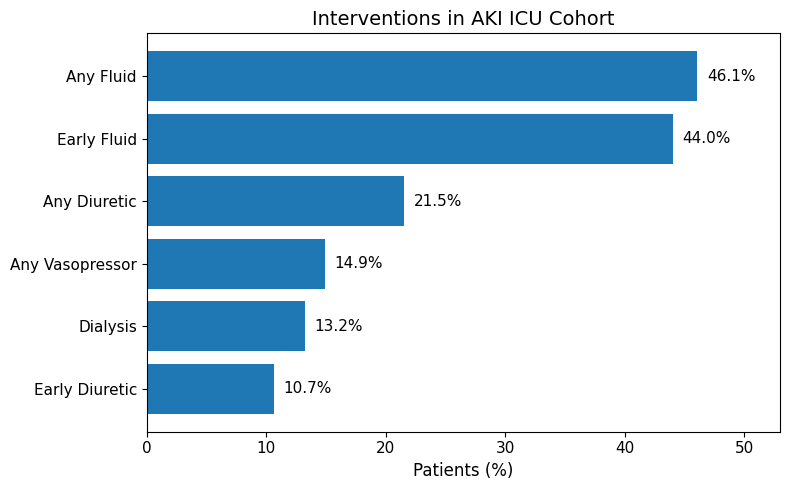

In [9]:
cols = [
    "dialysis",
    "any_vasopressor",
    "early_fluid",
    "any_fluid",
    "early_diuretic",
    "any_diuretic",
]

fig = plot_interventions(
    df,
    cols,
    title="Interventions in AKI ICU Cohort"
)
plt.show()


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_mortality_by_intervention(
    df,
    interventions,
    mortality_col="hospital_mortality",
    figsize=(9, 5),
    title="Hospital Mortality by Intervention Status"
):
    rows = []

    for c in interventions:
        if c not in df.columns:
            continue

        for val, label in [(1, "Yes"), (0, "No")]:
            sub = df[df[c] == val]
            if len(sub) == 0:
                continue

            mort = pd.to_numeric(sub[mortality_col], errors="coerce")
            rows.append({
                "Intervention": c.replace("_", " ").title(),
                "Group": label,
                "Mortality": 100 * mort.mean(),
                "N": len(sub),
            })

    plot_df = pd.DataFrame(rows)

    # Order by mortality in YES group
    order = (
        plot_df[plot_df["Group"] == "Yes"]
        .sort_values("Mortality")["Intervention"]
    )

    fig, ax = plt.subplots(figsize=figsize)

    y = np.arange(len(order))
    width = 0.35

    yes = plot_df[plot_df["Group"] == "Yes"].set_index("Intervention").loc[order]
    no  = plot_df[plot_df["Group"] == "No"].set_index("Intervention").loc[order]

    ax.barh(y - width/2, no["Mortality"], height=width, label="No")
    ax.barh(y + width/2, yes["Mortality"], height=width, label="Yes")

    # --- Labels: % and n
    for i, name in enumerate(order):
        ax.text(
            no.loc[name, "Mortality"] + 0.6,
            i - width/2,
            f'{no.loc[name, "Mortality"]:.1f}%  (n={no.loc[name, "N"]})',
            va="center",
            fontsize=10
        )
        ax.text(
            yes.loc[name, "Mortality"] + 0.6,
            i + width/2,
            f'{yes.loc[name, "Mortality"]:.1f}%  (n={yes.loc[name, "N"]})',
            va="center",
            fontsize=10
        )

    ax.set_yticks(y)
    ax.set_yticklabels(order, fontsize=11)
    ax.set_xlabel("Hospital Mortality (%)", fontsize=12)
    ax.set_title(title, fontsize=14)

    ax.legend(frameon=False)
    ax.set_xlim(0, max(plot_df["Mortality"]) * 1.25)

    plt.tight_layout()
    return fig


In [21]:
df["early_vasopressor"] = (
    (df["early_norepinephrine"] == 1) |
    (df["early_epinephrine"] == 1) |
    (df["early_phenylephrine"] == 1)
).astype(int)
(df["early_vasopressor"] == df["any_vasopressor"]).all()


np.True_

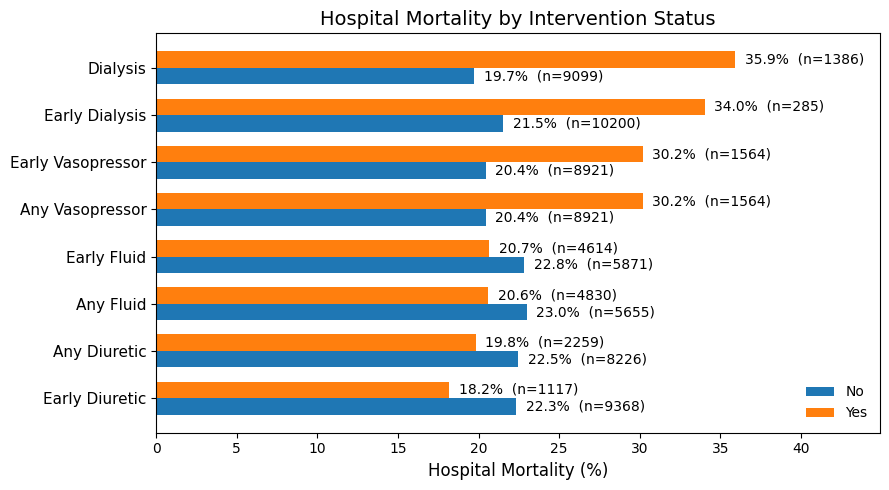

In [22]:
interventions = [
    "dialysis",
    "early_dialysis",
    "any_vasopressor",
    "early_vasopressor",
    "any_fluid",
    "early_fluid",
    "any_diuretic",
    "early_diuretic",

]

fig = plot_mortality_by_intervention(
    df,
    interventions,
    mortality_col="hospital_mortality",
    title="Hospital Mortality by Intervention Status"
)

plt.show()


In [25]:
import pandas as pd
import numpy as np
from src.db import q

def first_intervention_timing(
    df,
    patterns,
    label,
):
    """
    Adds two columns:
      - first_<label>_hours
      - first_<label>_timing  ∈ {0–12 h, 12–24 h, >24 h, No intervention}
    """

    where = " OR ".join([f"LOWER(di.label) LIKE '{p}'" for p in patterns])

    ev = q(f"""
        SELECT ie.icustay_id, ie.starttime
        FROM inputevents_mv ie
        JOIN d_items di ON ie.itemid = di.itemid
        WHERE {where}
    """)

    ev = ev.merge(
        df[["icustay_id", "intime"]],
        on="icustay_id",
        how="inner"
    ).dropna(subset=["starttime", "intime"])

    ev["hours_since_icu"] = (
        ev["starttime"] - ev["intime"]
    ).dt.total_seconds() / 3600

    ev = ev[ev["hours_since_icu"] >= 0]

    first_ev = (
        ev.sort_values(["icustay_id", "hours_since_icu"])
          .groupby("icustay_id", as_index=False)
          .first()[["icustay_id", "hours_since_icu"]]
    )

    out = df.merge(first_ev, on="icustay_id", how="left")

    timing_col = f"first_{label}_timing"
    hours_col = f"first_{label}_hours"

    out[hours_col] = out["hours_since_icu"]

    out[timing_col] = np.select(
        [
            out[hours_col].between(0, 12, inclusive="left"),
            out[hours_col].between(12, 24, inclusive="left"),
            out[hours_col] > 24,
            out[hours_col].isna(),
        ],
        [
            "0–12 h",
            "12–24 h",
            ">24 h",
            "No intervention",
        ],
        default="Other",
    )

    out[timing_col] = pd.Categorical(
        out[timing_col],
        categories=["0–12 h", "12–24 h", ">24 h", "No intervention"],
        ordered=True
    )

    return out.drop(columns=["hours_since_icu"])


In [26]:
VASO_PATTERNS = [
    "%norepinephrine%", "%epinephrine%",
    "%phenylephrine%", "%vasopressin%",
]

FLUID_PATTERNS = [
    "%normal saline%", "%0.9%saline%", "%saline%",
    "%lactated ring%", "%ringer%",
    "%plasmalyte%", "%plasma-lyte%",
    "%d5w%", "%dextrose%",
    "%albumin%",
    "%packed red%", "%prbc%", "%red blood cell%",
    "%fresh frozen plasma%", "%ffp%",
    "%platelet%",
]

DIURETIC_PATTERNS = [
    "%furosemide%", "%lasix%",
    "%bumetanide%", "%torsemide%",
    "%chlorothiazide%", "%metolazone%",
    "%mannitol%", "%acetazolamide%",
]


In [27]:
df3 = df.copy()

df3 = first_intervention_timing(df3, VASO_PATTERNS, "vaso")
df3 = first_intervention_timing(df3, FLUID_PATTERNS, "fluid")
df3 = first_intervention_timing(df3, DIURETIC_PATTERNS, "diuretic")


In [28]:
def mortality_by_timing(df, timing_col, mortality_col="hospital_mortality"):
    out = (
        df
        .groupby(timing_col)
        .agg(
            n=(mortality_col, "size"),
            mortality_pct=(mortality_col, "mean"),
        )
        .reset_index()
    )
    out["mortality_pct"] *= 100
    return out


In [29]:
mort_vaso = mortality_by_timing(df3, "first_vaso_timing")
mort_fluid = mortality_by_timing(df3, "first_fluid_timing")
mort_diur = mortality_by_timing(df3, "first_diuretic_timing")

mort_vaso, mort_fluid, mort_diur


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2454756539.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2454756539.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2454756539.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


(  first_vaso_timing     n  mortality_pct
 0            0–12 h  1419      29.668781
 1           12–24 h   148      35.135135
 2             >24 h   376      49.734043
 3   No intervention  8542      19.140716,
   first_fluid_timing     n  mortality_pct
 0             0–12 h  4291      21.090655
 1            12–24 h   323      15.170279
 2              >24 h   214      19.158879
 3    No intervention  5657      22.980378,
   first_diuretic_timing     n  mortality_pct
 0                0–12 h   690      19.710145
 1               12–24 h   427      15.690867
 2                 >24 h  1142      21.453590
 3       No intervention  8226      22.453197)

In [30]:
import matplotlib.pyplot as plt

def plot_combined_mortality_by_timing(
    df,
    timing_cols,
    titles,
    mortality_col="hospital_mortality",
    figsize=(12, 4),
):
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)

    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    for ax, timing_col, title in zip(axes, timing_cols, titles):
        tmp = (
            df
            .groupby(timing_col)
            .agg(
                n=(mortality_col, "size"),
                mort=(mortality_col, "mean"),
            )
            .reindex(order)
            .reset_index()
        )

        tmp["mort"] *= 100

        ax.bar(
            tmp[timing_col],
            tmp["mort"]
        )

        for i, row in tmp.iterrows():
            if pd.isna(row["mort"]):
                continue
            ax.text(
                i,
                row["mort"] + 0.8,
                f'{row["mort"]:.1f}%\n(n={int(row["n"])})',
                ha="center",
                va="bottom",
                fontsize=11
            )

        ax.set_title(title, fontsize=13)
        ax.set_xlabel("Timing of first intervention", fontsize=11)
        ax.tick_params(axis="x", labelrotation=0, labelsize=11)

    axes[0].set_ylabel("Hospital Mortality (%)", fontsize=12)
    axes[0].set_ylim(0, df[mortality_col].mean() * 200)

    fig.suptitle(
        "Hospital Mortality by Timing of First Intervention",
        fontsize=15,
        y=1.05
    )

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1303331525.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1303331525.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1303331525.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


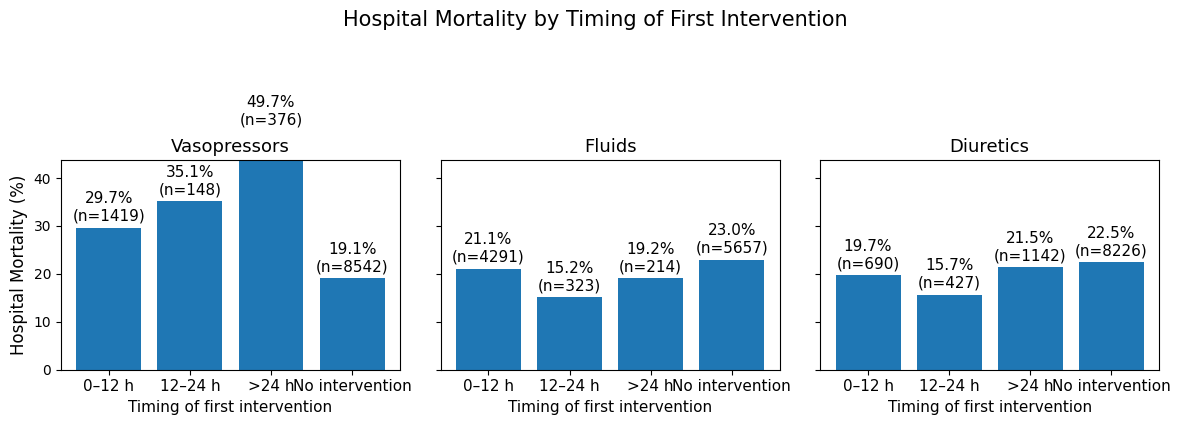

In [31]:
fig = plot_combined_mortality_by_timing(
    df3,
    timing_cols=[
        "first_vaso_timing",
        "first_fluid_timing",
        "first_diuretic_timing",
    ],
    titles=[
        "Vasopressors",
        "Fluids",
        "Diuretics",
    ],
)

plt.show()


In [32]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_mortality_by_timing_single(
    df,
    timing_col,
    title,
    mortality_col="hospital_mortality",
    colors=None,
    figsize=(4.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    if colors is None:
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#7f7f7f"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=(mortality_col, "size"),
            mort=(mortality_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["mort"] *= 100

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(
        tmp[timing_col],
        tmp["mort"],
        color=colors
    )

    for i, row in tmp.iterrows():
        if pd.isna(row["mort"]):
            continue
        ax.text(
            i,
            row["mort"] + 0.8,
            f'{row["mort"]:.1f}%\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=11
        )

    ax.set_ylabel("Hospital Mortality (%)", fontsize=12)
    ax.set_xlabel("Timing of first intervention", fontsize=11)
    ax.set_title(title, fontsize=14)

    ax.set_ylim(0, max(tmp["mort"].max() * 1.25, 5))
    ax.tick_params(axis="x", labelsize=11)

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\586205683.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


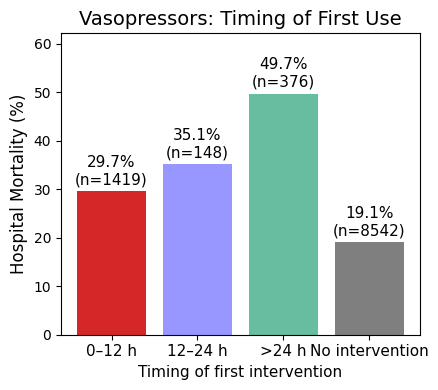

In [34]:
fig_vaso = plot_mortality_by_timing_single(
    df3,
    timing_col="first_vaso_timing",
    title="Vasopressors: Timing of First Use",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\586205683.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


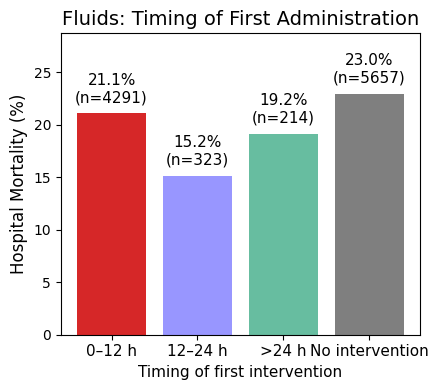

In [36]:
fig_fluid = plot_mortality_by_timing_single(
    df3,
    timing_col="first_fluid_timing",
    title="Fluids: Timing of First Administration",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\586205683.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


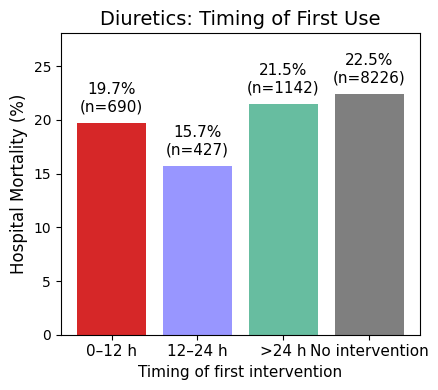

In [38]:
fig_diur = plot_mortality_by_timing_single(
    df3,
    timing_col="first_diuretic_timing",
    title="Diuretics: Timing of First Use",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
    
)

plt.show()


In [39]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_rrt_persistence_by_timing_single(
    df,
    timing_col,
    title,
    outcome_col="rrt_persistent_last6h",
    colors=None,
    figsize=(4.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    if colors is None:
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#7f7f7f"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=(outcome_col, "size"),
            rate=(outcome_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["rate"] *= 100

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(
        tmp[timing_col],
        tmp["rate"],
        color=colors
    )

    for i, row in tmp.iterrows():
        if pd.isna(row["rate"]):
            continue
        ax.text(
            i,
            row["rate"] + 0.8,
            f'{row["rate"]:.1f}%\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=11
        )

    ax.set_ylabel("Persistent RRT at ICU Discharge (%)", fontsize=12)
    ax.set_xlabel("Timing of first intervention", fontsize=11)
    ax.set_title(title, fontsize=14)

    ax.set_ylim(0, max(tmp["rate"].max() * 1.25, 5))
    ax.tick_params(axis="x", labelsize=11)

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\448871382.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


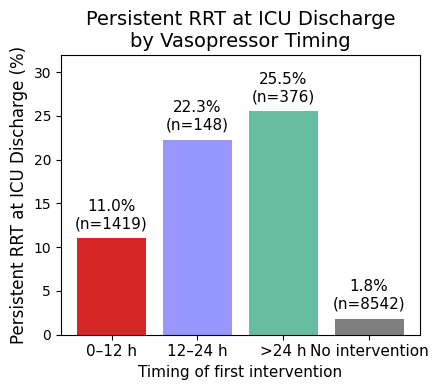

In [44]:
fig_vaso_rrt = plot_rrt_persistence_by_timing_single(
    df3,
    timing_col="first_vaso_timing",
    title="Persistent RRT at ICU Discharge\nby Vasopressor Timing",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\448871382.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


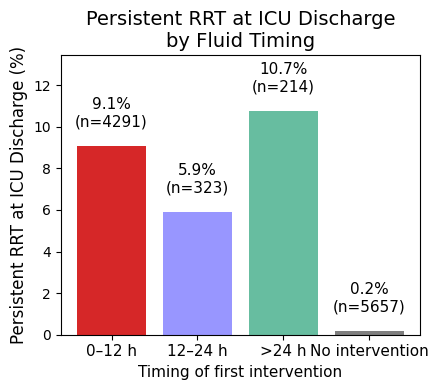

In [45]:
fig_fluid_rrt = plot_rrt_persistence_by_timing_single(
    df3,
    timing_col="first_fluid_timing",
    title="Persistent RRT at ICU Discharge\nby Fluid Timing",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\448871382.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


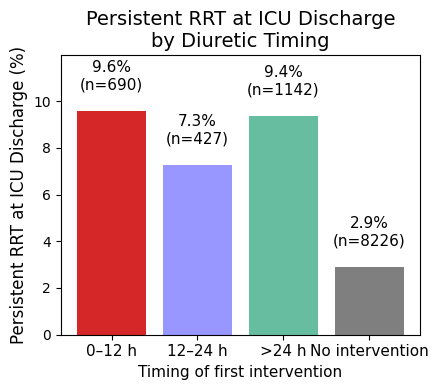

In [47]:
fig_diur_rrt = plot_rrt_persistence_by_timing_single(
    df3,
    timing_col="first_diuretic_timing",
    title="Persistent RRT at ICU Discharge\nby Diuretic Timing",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()


In [51]:
import pandas as pd

def score_summary_by_timing(
    df,
    timing_col,
):
    out = (
        df
        .groupby(timing_col)
        .agg(
            n=("icustay_id", "size"),
            sofa_mean=("sofa", "mean"),
            sofa_sd=("sofa", "std"),
            sofa_renal_mean=("sofa_renal", "mean"),
            sofa_renal_sd=("sofa_renal", "std"),
            sapsii_mean=("sapsii", "mean"),
            sapsii_sd=("sapsii", "std"),
        )
        .reset_index()
    )

    out["SOFA total (mean ± SD)"] = out.apply(
        lambda r: f"{r['sofa_mean']:.1f} ± {r['sofa_sd']:.1f}", axis=1
    )
    out["SOFA renal (mean ± SD)"] = out.apply(
        lambda r: f"{r['sofa_renal_mean']:.1f} ± {r['sofa_renal_sd']:.1f}", axis=1
    )
    out["SAPS II (mean ± SD)"] = out.apply(
        lambda r: f"{r['sapsii_mean']:.1f} ± {r['sapsii_sd']:.1f}", axis=1
    )

    return out[
        [
            timing_col,
            "n",
            "SOFA total (mean ± SD)",
            "SOFA renal (mean ± SD)",
            "SAPS II (mean ± SD)",
        ]
    ]


In [52]:
scores_vaso = score_summary_by_timing(df3, "first_vaso_timing")
scores_fluid = score_summary_by_timing(df3, "first_fluid_timing")
scores_diur = score_summary_by_timing(df3, "first_diuretic_timing")

scores_vaso, scores_fluid, scores_diur



C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1783744738.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1783744738.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1783744738.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


(  first_vaso_timing     n SOFA total (mean ± SD) SOFA renal (mean ± SD)  \
 0            0–12 h  1419              9.0 ± 3.9              1.9 ± 1.3   
 1           12–24 h   148              9.2 ± 3.7              2.0 ± 1.4   
 2             >24 h   376              6.1 ± 3.3              1.6 ± 1.3   
 3   No intervention  8542              5.5 ± 3.3              1.7 ± 1.2   
 
   SAPS II (mean ± SD)  
 0         51.2 ± 16.2  
 1         53.6 ± 13.9  
 2         44.0 ± 13.9  
 3         41.1 ± 14.3  ,
   first_fluid_timing     n SOFA total (mean ± SD) SOFA renal (mean ± SD)  \
 0             0–12 h  4291              6.5 ± 3.8              1.7 ± 1.2   
 1            12–24 h   323              5.3 ± 2.9              1.7 ± 1.1   
 2              >24 h   214              4.8 ± 2.5              1.6 ± 1.2   
 3    No intervention  5657              5.9 ± 3.6              1.8 ± 1.2   
 
   SAPS II (mean ± SD)  
 0         43.8 ± 15.3  
 1         41.1 ± 13.0  
 2         38.4 ± 12.4  
 3   

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scores_by_timing(
    df,
    timing_col,
    title,
    figsize=(6.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=("icustay_id", "size"),
            sofa=("sofa", "mean"),
            sofa_renal=("sofa_renal", "mean"),
            sapsii=("sapsii", "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    x = np.arange(len(order))
    width = 0.25

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(x - width, tmp["sofa"], width, label="SOFA total")
    ax.bar(x,         tmp["sofa_renal"], width, label="SOFA renal")
    ax.bar(x + width, tmp["sapsii"], width, label="SAPS II")

    for i, row in tmp.iterrows():
        ax.text(
            x[i],
            max(row["sofa"], row["sofa_renal"], row["sapsii"]) + 0.8,
            f"n={int(row['n'])}",
            ha="center",
            fontsize=10
        )

    ax.set_xticks(x)
    ax.set_xticklabels(order, fontsize=11)
    ax.set_ylabel("Mean score", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(frameon=False)

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\4245607479.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\4245607479.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\4245607479.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


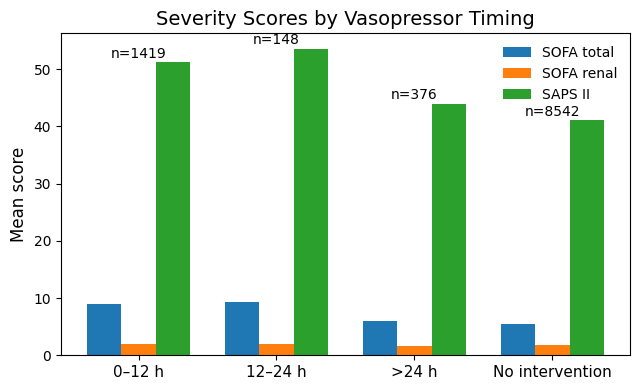

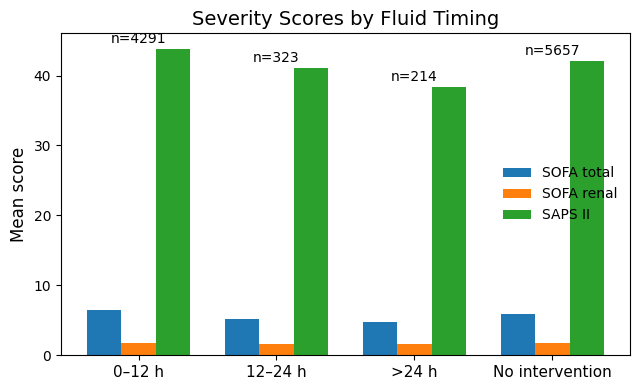

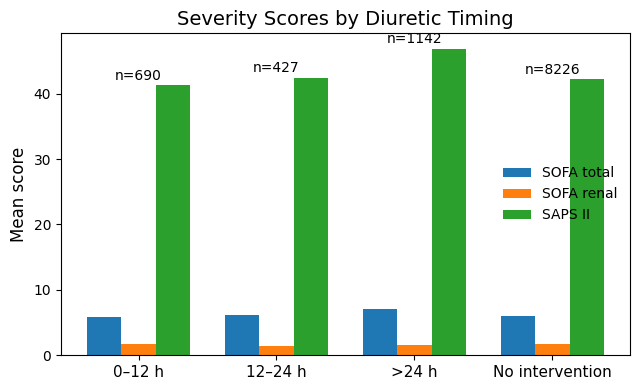

In [54]:
fig_vaso_scores = plot_scores_by_timing(
    df3,
    "first_vaso_timing",
    "Severity Scores by Vasopressor Timing",
)

fig_fluid_scores = plot_scores_by_timing(
    df3,
    "first_fluid_timing",
    "Severity Scores by Fluid Timing",
)

fig_diur_scores = plot_scores_by_timing(
    df3,
    "first_diuretic_timing",
    "Severity Scores by Diuretic Timing",
)

plt.show()


In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_score_by_timing(
    df,
    timing_col,
    score_col,
    title,
    ylabel,
    color="#1f77b4",
    figsize=(4.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=("icustay_id", "size"),
            mean_score=(score_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(
        tmp[timing_col],
        tmp["mean_score"],
        color=color,
    )

    for i, row in tmp.iterrows():
        if pd.isna(row["mean_score"]):
            continue
        ax.text(
            i,
            row["mean_score"] + 0.5,
            f'{row["mean_score"]:.1f}\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=11
        )

    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel("Timing of first intervention", fontsize=11)
    ax.tick_params(axis="x", labelsize=11)

    ax.set_ylim(0, max(tmp["mean_score"].max() * 1.25, 3))
    plt.tight_layout()
    return fig


In [56]:
def plot_mortality_by_timing(
    df,
    timing_col,
    title,
    mortality_col="hospital_mortality",
    color="#d62728",
    figsize=(4.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=(mortality_col, "size"),
            mort=(mortality_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["mort"] *= 100

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(
        tmp[timing_col],
        tmp["mort"],
        color=color,
    )

    for i, row in tmp.iterrows():
        if pd.isna(row["mort"]):
            continue
        ax.text(
            i,
            row["mort"] + 0.8,
            f'{row["mort"]:.1f}%\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=11
        )

    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Hospital Mortality (%)", fontsize=12)
    ax.set_xlabel("Timing of first intervention", fontsize=11)
    ax.tick_params(axis="x", labelsize=11)

    ax.set_ylim(0, max(tmp["mort"].max() * 1.25, 5))
    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2917335501.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2917335501.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2917335501.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppD

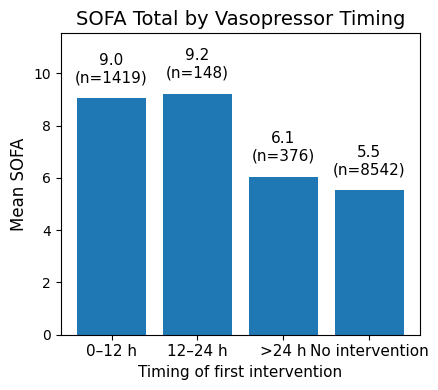

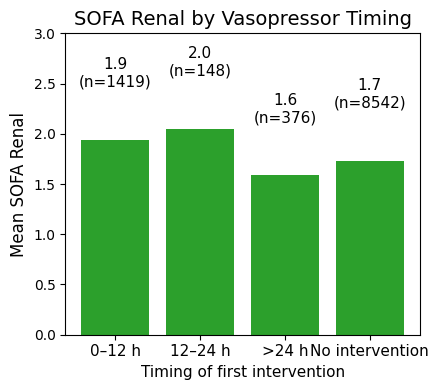

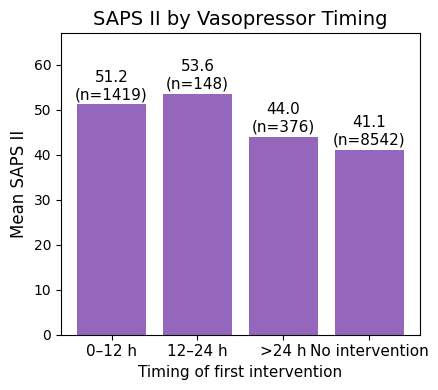

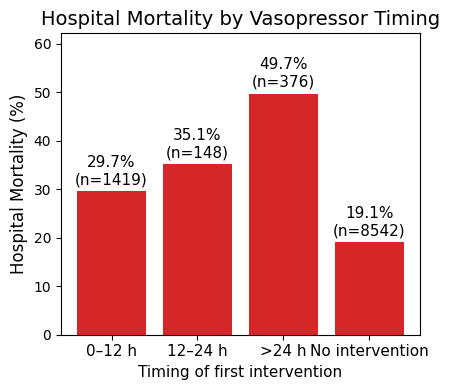

In [57]:
fig_sofa_vaso = plot_score_by_timing(
    df3,
    "first_vaso_timing",
    score_col="sofa",
    title="SOFA Total by Vasopressor Timing",
    ylabel="Mean SOFA",
    color="#1f77b4",
)

fig_sofa_renal_vaso = plot_score_by_timing(
    df3,
    "first_vaso_timing",
    score_col="sofa_renal",
    title="SOFA Renal by Vasopressor Timing",
    ylabel="Mean SOFA Renal",
    color="#2ca02c",
)

fig_saps_vaso = plot_score_by_timing(
    df3,
    "first_vaso_timing",
    score_col="sapsii",
    title="SAPS II by Vasopressor Timing",
    ylabel="Mean SAPS II",
    color="#9467bd",
)

fig_mort_vaso = plot_mortality_by_timing(
    df3,
    "first_vaso_timing",
    title="Hospital Mortality by Vasopressor Timing",
)

plt.show()


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_score_with_mortality_overlay(
    df,
    timing_col,
    score_col,
    mortality_col="hospital_mortality",
    title="",
    score_ylabel="Mean score",
    mort_ylabel="Hospital mortality (%)",
    score_color="#1f77b4",
    mort_color="#d62728",
    figsize=(5.2, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=("icustay_id", "size"),
            score_mean=(score_col, "mean"),
            mort_mean=(mortality_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["mort_pct"] = tmp["mort_mean"] * 100

    x = np.arange(len(order))

    fig, ax1 = plt.subplots(figsize=figsize)

    # Bars = score
    ax1.bar(x, tmp["score_mean"], color=score_color, alpha=0.9)
    ax1.set_ylabel(score_ylabel, fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(order, fontsize=11)
    ax1.set_title(title, fontsize=14)

    # annotate score + n
    for i, row in tmp.iterrows():
        if pd.isna(row["score_mean"]):
            continue
        ax1.text(
            i,
            row["score_mean"] + (0.03 * tmp["score_mean"].max() if tmp["score_mean"].max() > 0 else 0.2),
            f'{row["score_mean"]:.1f}\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=10
        )

    ax1.set_ylim(0, max(tmp["score_mean"].max() * 1.25, 1))

    # Line = mortality on secondary axis
    ax2 = ax1.twinx()
    ax2.plot(x, tmp["mort_pct"], color=mort_color, marker="o", linewidth=2.5)
    ax2.set_ylabel(mort_ylabel, fontsize=12)

    for i, row in tmp.iterrows():
        if pd.isna(row["mort_pct"]):
            continue
        ax2.text(
            i,
            row["mort_pct"] + 0.8,
            f'{row["mort_pct"]:.1f}%',
            ha="center",
            va="bottom",
            fontsize=10,
            color=mort_color
        )

    ax2.set_ylim(0, max(tmp["mort_pct"].max() * 1.35, 5))

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


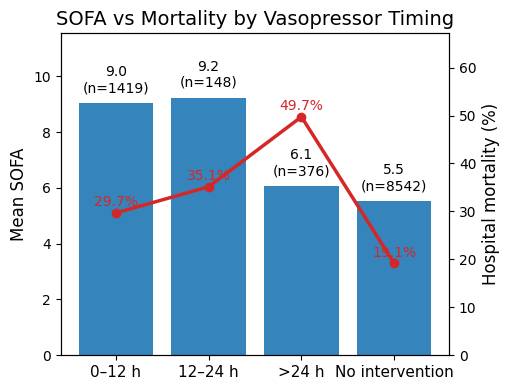

In [59]:
fig = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sofa",
    title="SOFA vs Mortality by Vasopressor Timing",
    score_ylabel="Mean SOFA",
    mort_ylabel="Hospital mortality (%)",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


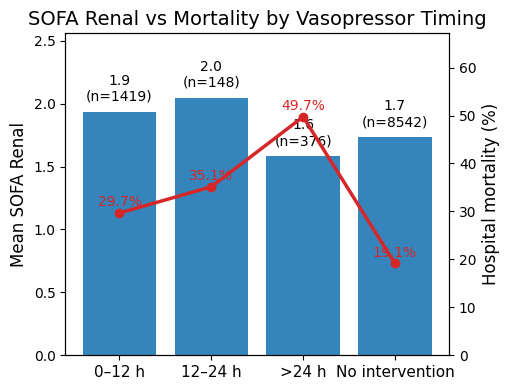

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


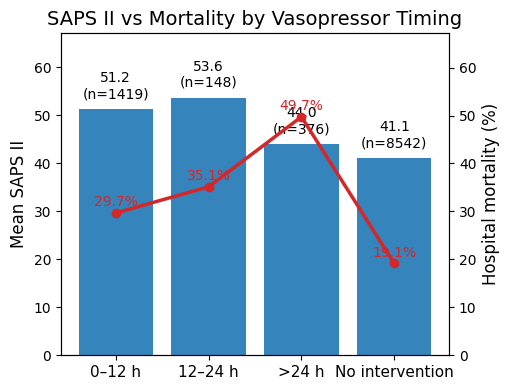

In [74]:
fig_sofa_renal = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Mortality by Vasopressor Timing",
    score_ylabel="Mean SOFA Renal",
    mort_ylabel="Hospital mortality (%)",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()

fig_saps = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sapsii",
    title="SAPS II vs Mortality by Vasopressor Timing",
    score_ylabel="Mean SAPS II",
    mort_ylabel="Hospital mortality (%)",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


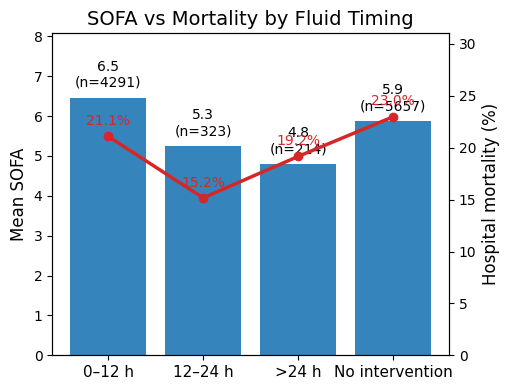

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


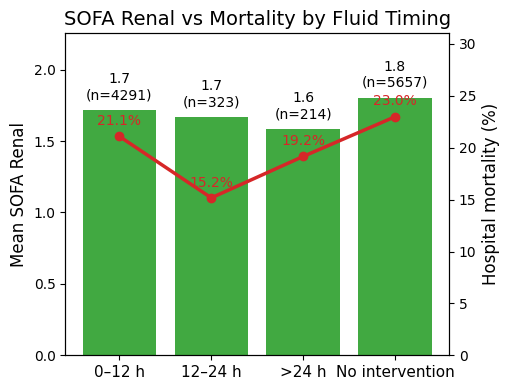

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


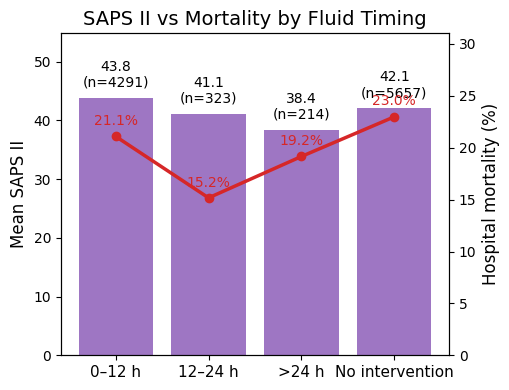

In [ ]:
# Fluids — SOFA total + mortality
fig_fluid_sofa = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sofa",
    title="SOFA vs Mortality by Fluid Timing",
    score_ylabel="Mean SOFA",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()

# Fluids — SOFA renal + mortality
fig_fluid_renal = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Mortality by Fluid Timing",
    score_ylabel="Mean SOFA Renal",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()

# Fluids — SAPS II + mortality
fig_fluid_saps = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sapsii",
    title="SAPS II vs Mortality by Fluid Timing",
    score_ylabel="Mean SAPS II",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


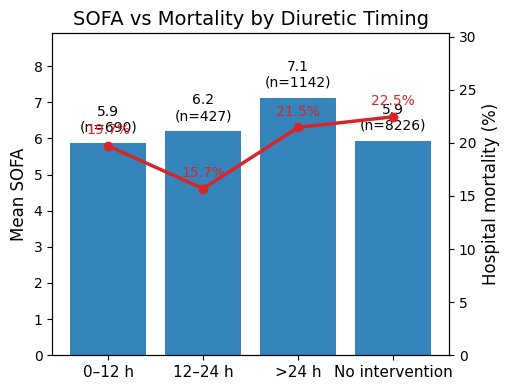

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


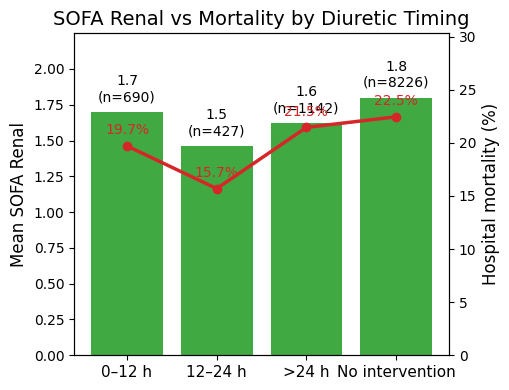

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


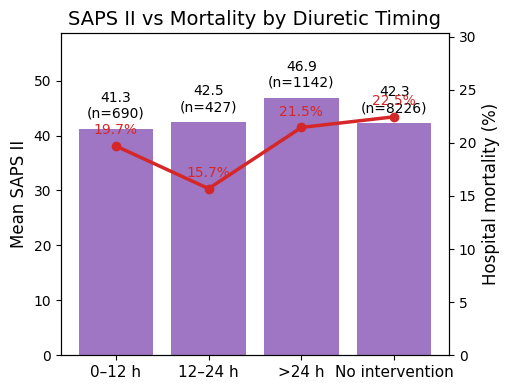

In [ ]:
# Diuretics — SOFA total + mortality
fig_diur_sofa = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sofa",
    title="SOFA vs Mortality by Diuretic Timing",
    score_ylabel="Mean SOFA",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()

# Diuretics — SOFA renal + mortality
fig_diur_renal = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Mortality by Diuretic Timing",
    score_ylabel="Mean SOFA Renal",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()

# Diuretics — SAPS II + mortality
fig_diur_saps = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sapsii",
    title="SAPS II vs Mortality by Diuretic Timing",
    score_ylabel="Mean SAPS II",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_score_with_rrt_overlay(
    df,
    timing_col,
    score_col,
    outcome_col="rrt_persistent_last6h",
    title="",
    score_ylabel="Mean score",
    rrt_ylabel="Persistent RRT at ICU discharge (%)",
    score_color="#1f77b4",
    rrt_color="#d01515",
    figsize=(5.2, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=("icustay_id", "size"),
            score_mean=(score_col, "mean"),
            rrt_mean=(outcome_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["rrt_pct"] = tmp["rrt_mean"] * 100
    x = np.arange(len(order))

    fig, ax1 = plt.subplots(figsize=figsize)

    # --- Bars: score
    ax1.bar(x, tmp["score_mean"], color=score_color, alpha=0.9)
    ax1.set_ylabel(score_ylabel, fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(order, fontsize=11)
    ax1.set_title(title, fontsize=14)

    for i, row in tmp.iterrows():
        if pd.isna(row["score_mean"]):
            continue
        ax1.text(
            i,
            row["score_mean"] + max(tmp["score_mean"].max() * 0.03, 0.2),
            f'{row["score_mean"]:.1f}\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=10
        )

    ax1.set_ylim(0, max(tmp["score_mean"].max() * 1.25, 1))

    # --- Line: RRT persistence
    ax2 = ax1.twinx()
    ax2.plot(
        x,
        tmp["rrt_pct"],
        color=rrt_color,
        marker="o",
        linewidth=2.5
    )
    ax2.set_ylabel(rrt_ylabel, fontsize=12)

    for i, row in tmp.iterrows():
        if pd.isna(row["rrt_pct"]):
            continue
        ax2.text(
            i,
            row["rrt_pct"] + 0.8,
            f'{row["rrt_pct"]:.1f}%',
            ha="center",
            va="bottom",
            fontsize=10,
            color=rrt_color
        )

    ax2.set_ylim(0, max(tmp["rrt_pct"].max() * 1.35, 5))

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


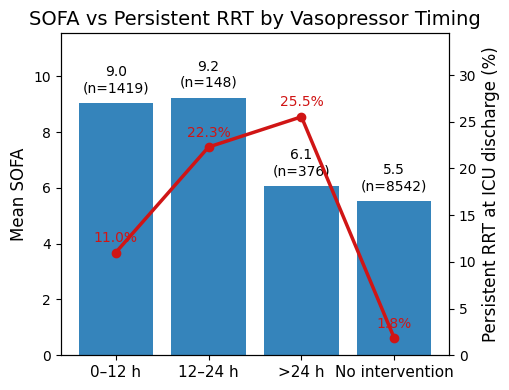

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


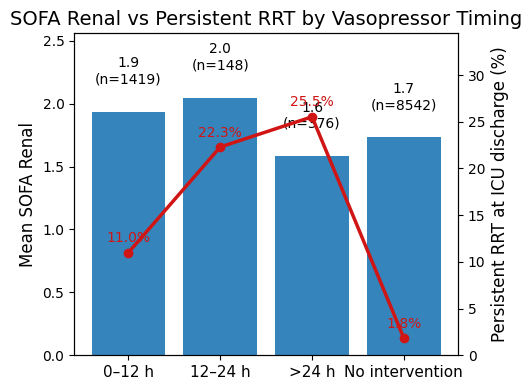

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


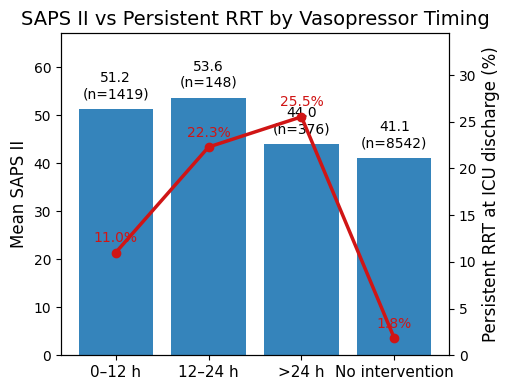

In [71]:
# SOFA total
plot_score_with_rrt_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sofa",
    title="SOFA vs Persistent RRT by Vasopressor Timing",
    score_ylabel="Mean SOFA",
    score_color="#1f77b4",
); plt.show()

# SOFA renal
plot_score_with_rrt_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Persistent RRT by Vasopressor Timing",
    score_ylabel="Mean SOFA Renal",
    score_color="#1f77b4",
); plt.show()

# SAPS II
plot_score_with_rrt_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sapsii",
    title="SAPS II vs Persistent RRT by Vasopressor Timing",
    score_ylabel="Mean SAPS II",
    score_color="#1f77b4", 
); plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


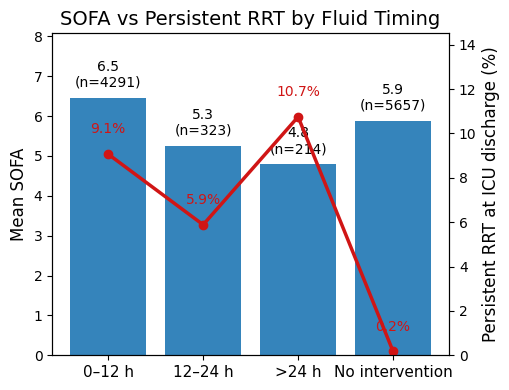

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


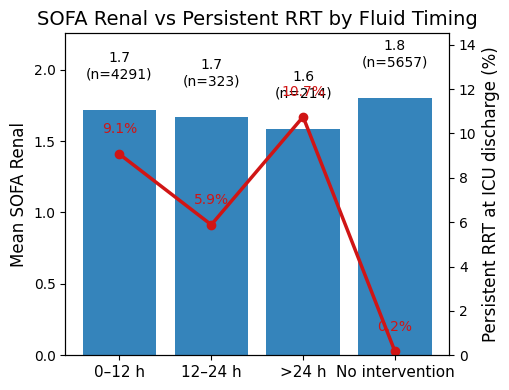

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


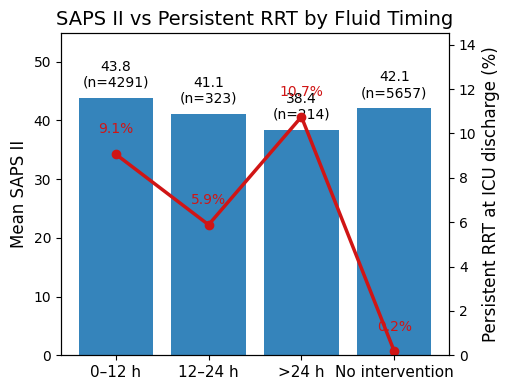

In [72]:
plot_score_with_rrt_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sofa",
    title="SOFA vs Persistent RRT by Fluid Timing",
    score_ylabel="Mean SOFA",
    score_color="#1f77b4",
); plt.show()

plot_score_with_rrt_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Persistent RRT by Fluid Timing",
    score_ylabel="Mean SOFA Renal",
    score_color="#1f77b4",
); plt.show()

plot_score_with_rrt_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sapsii",
    title="SAPS II vs Persistent RRT by Fluid Timing",
    score_ylabel="Mean SAPS II",
    score_color="#1f77b4",
); plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


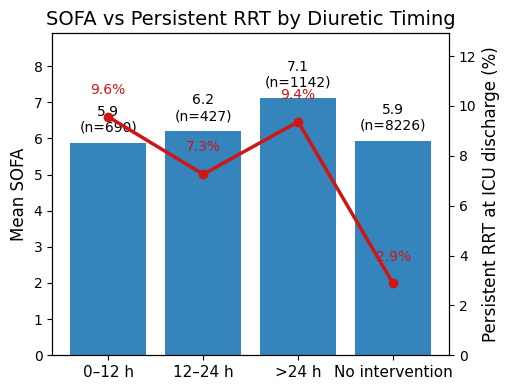

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


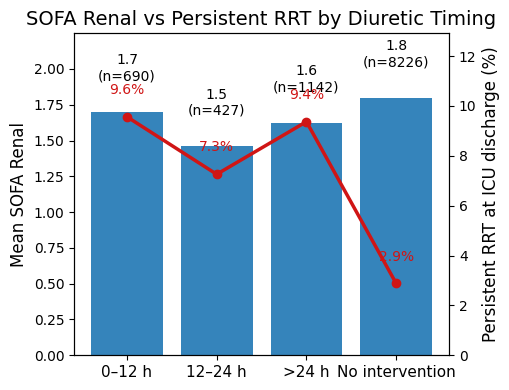

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


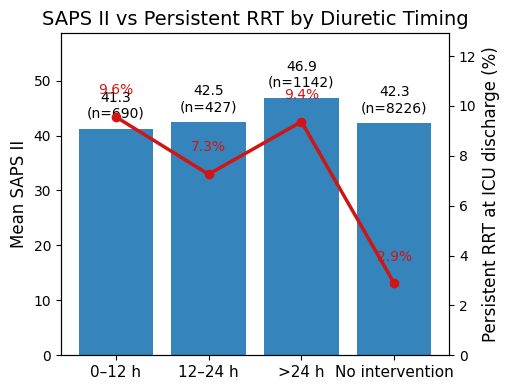

In [73]:
plot_score_with_rrt_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sofa",
    title="SOFA vs Persistent RRT by Diuretic Timing",
    score_ylabel="Mean SOFA",
    score_color="#1f77b4",
); plt.show()

plot_score_with_rrt_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Persistent RRT by Diuretic Timing",
    score_ylabel="Mean SOFA Renal",
    score_color="#1f77b4",
); plt.show()

plot_score_with_rrt_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sapsii",
    title="SAPS II vs Persistent RRT by Diuretic Timing",
    score_ylabel="Mean SAPS II",
    score_color="#1f77b4",
); plt.show()


In [75]:
import pandas as pd
import numpy as np

def add_score_bins(df, score_col, n_bins=4, prefix=None):
    out = df.copy()
    if prefix is None:
        prefix = score_col

    # Quartile (robust, gleich große Gruppen)
    out[f"{prefix}_bin"] = pd.qcut(out[score_col], q=n_bins, duplicates="drop")
    return out

def hours_to_timing_group(hours_series):
    return pd.Categorical(
        np.select(
            [
                hours_series.between(0, 12, inclusive="left"),
                hours_series.between(12, 24, inclusive="left"),
                hours_series > 24,
                hours_series.isna(),
            ],
            ["0–12 h", "12–24 h", ">24 h", "No intervention"],
            default="Other",
        ),
        categories=["0–12 h", "12–24 h", ">24 h", "No intervention"],
        ordered=True
    )

# falls du nur *_timing hast, kannst du diesen Schritt überspringen
df4 = df3.copy()
df4["vaso_timing"] = hours_to_timing_group(df4.get("first_vaso_hours", np.nan))
df4["fluid_timing"] = hours_to_timing_group(df4.get("first_fluid_hours", np.nan))
df4["diuretic_timing"] = hours_to_timing_group(df4.get("first_diuretic_hours", np.nan))

# Score bins (Quartile) – du kannst auch n_bins=5 machen etc.
df4 = add_score_bins(df4, "sofa", n_bins=4, prefix="sofa")
df4 = add_score_bins(df4, "sofa_renal", n_bins=4, prefix="sofa_renal")
df4 = add_score_bins(df4, "sapsii", n_bins=4, prefix="sapsii")


In [76]:
def score_group_timing_stats(df, score_bin_col, timing_col, outcome_col="hospital_mortality"):
    # n und mortality pro Bin×Timing
    agg = (
        df.groupby([score_bin_col, timing_col])
          .agg(n=("icustay_id", "size"),
               mortality=(outcome_col, "mean"))
          .reset_index()
    )
    agg["mortality_pct"] = agg["mortality"] * 100

    # Timing-Verteilung innerhalb jedes Score-Bins
    agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")
    agg["within_bin_pct"] = 100 * agg["n"] / agg["bin_total"]
    return agg

stats_sofa_vaso = score_group_timing_stats(df4, "sofa_bin", "vaso_timing")
stats_sofa_fluid = score_group_timing_stats(df4, "sofa_bin", "fluid_timing")
stats_sofa_diur = score_group_timing_stats(df4, "sofa_bin", "diuretic_timing")

stats_sofa_vaso.head()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and 

,sofa_bin,vaso_timing,n,mortality,mortality_pct,bin_total,within_bin_pct
0,"(-0.001, 3.0]",0–12 h,76,0.105263,10.526316,2870,2.648084
1,"(-0.001, 3.0]",12–24 h,6,0.000000,0.000000,2870,0.209059
2,"(-0.001, 3.0]",>24 h,101,0.415842,41.584158,2870,3.519164
3,"(-0.001, 3.0]",No intervention,2687,0.086342,8.634164,2870,93.623693
4,"(3.0, 5.0]",0–12 h,183,0.131148,13.114754,2449,7.472438


In [77]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mortality_by_timing_within_score_bins(stats_df, score_bin_col, timing_col, title, figsize=(10, 4.5)):
    order_timing = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    bins = list(stats_df[score_bin_col].dropna().unique())
    bins = sorted(bins, key=lambda x: str(x))

    fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(len(bins))
    width = 0.2
    offsets = {"0–12 h": -1.5*width, "12–24 h": -0.5*width, ">24 h": 0.5*width, "No intervention": 1.5*width}

    for t in order_timing:
        sub = stats_df[stats_df[timing_col] == t].set_index(score_bin_col).reindex(bins)
        y = sub["mortality_pct"].values
        n = sub["n"].fillna(0).astype(int).values

        ax.bar(x + offsets[t], y, width, label=t)

        for i in range(len(bins)):
            if np.isnan(y[i]):
                continue
            ax.text(x[i] + offsets[t], y[i] + 0.6, f"n={n[i]}", ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels([str(b) for b in bins], rotation=0, fontsize=10)
    ax.set_ylabel("Hospital mortality (%)", fontsize=12)
    ax.set_xlabel("Score group (quantiles)", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(frameon=False, ncol=4)
    ax.set_ylim(0, max(stats_df["mortality_pct"].max() * 1.25, 5))

    plt.tight_layout()
    return fig


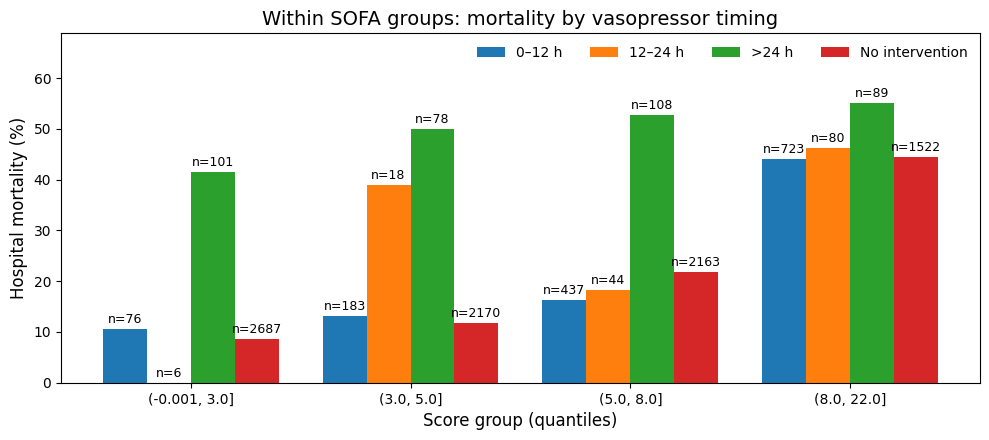

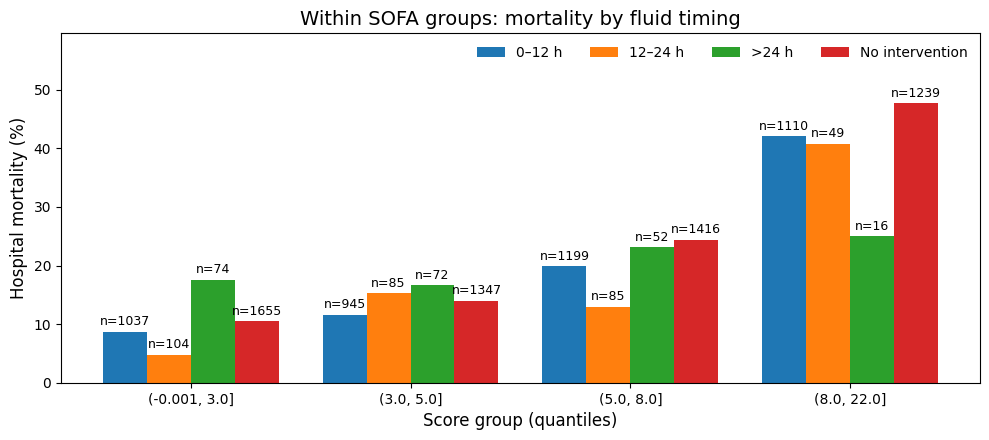

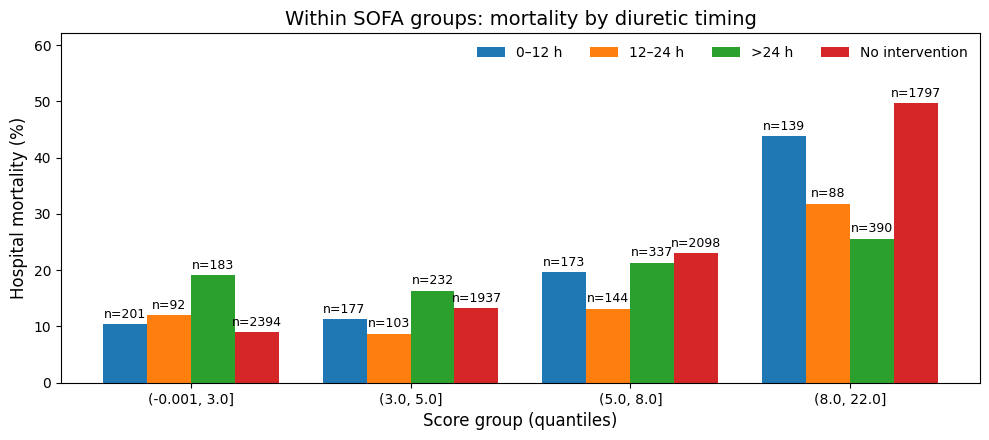

In [78]:
fig1 = plot_mortality_by_timing_within_score_bins(
    stats_sofa_vaso,
    score_bin_col="sofa_bin",
    timing_col="vaso_timing",
    title="Within SOFA groups: mortality by vasopressor timing"
)
plt.show()

fig2 = plot_mortality_by_timing_within_score_bins(
    stats_sofa_fluid,
    score_bin_col="sofa_bin",
    timing_col="fluid_timing",
    title="Within SOFA groups: mortality by fluid timing"
)
plt.show()

fig3 = plot_mortality_by_timing_within_score_bins(
    stats_sofa_diur,
    score_bin_col="sofa_bin",
    timing_col="diuretic_timing",
    title="Within SOFA groups: mortality by diuretic timing"
)
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


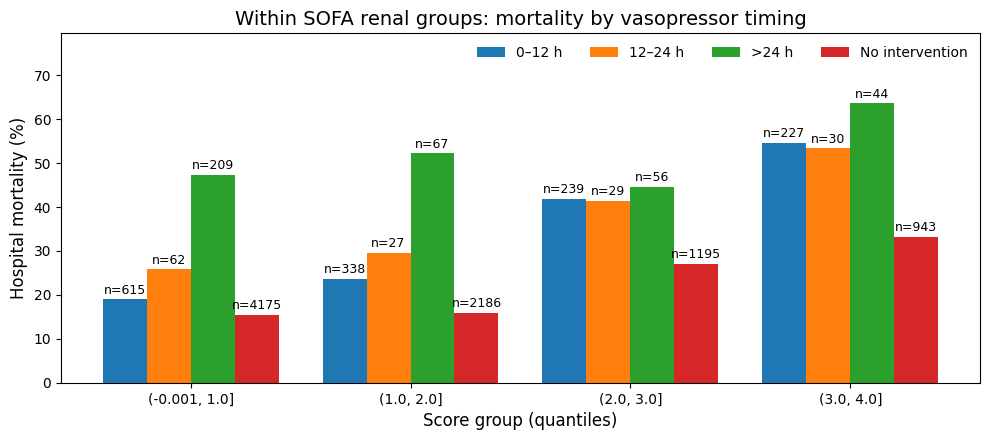

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


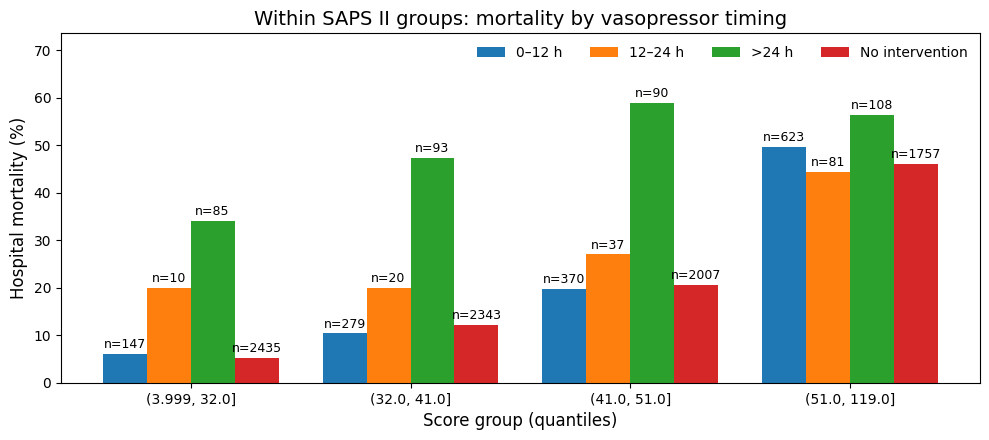

In [79]:
stats_renal_vaso = score_group_timing_stats(df4, "sofa_renal_bin", "vaso_timing")
plot_mortality_by_timing_within_score_bins(stats_renal_vaso, "sofa_renal_bin", "vaso_timing",
                                           "Within SOFA renal groups: mortality by vasopressor timing"); plt.show()

stats_saps_vaso = score_group_timing_stats(df4, "sapsii_bin", "vaso_timing")
plot_mortality_by_timing_within_score_bins(stats_saps_vaso, "sapsii_bin", "vaso_timing",
                                           "Within SAPS II groups: mortality by vasopressor timing"); plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


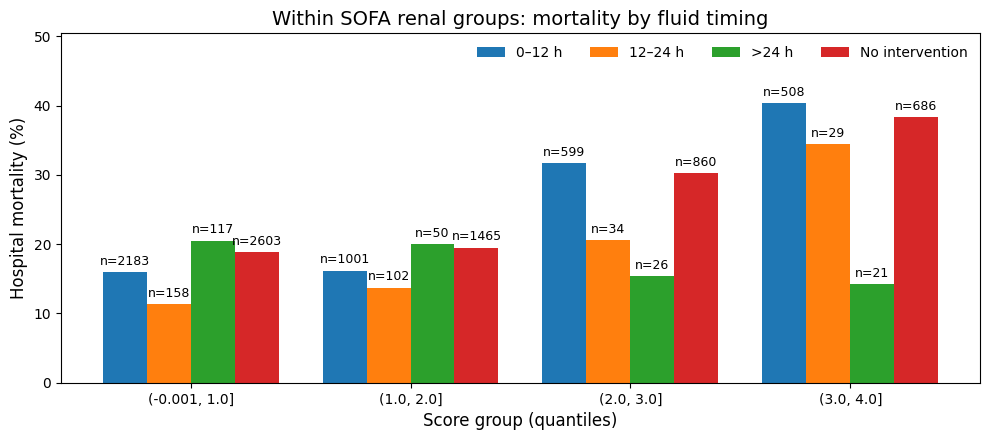

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


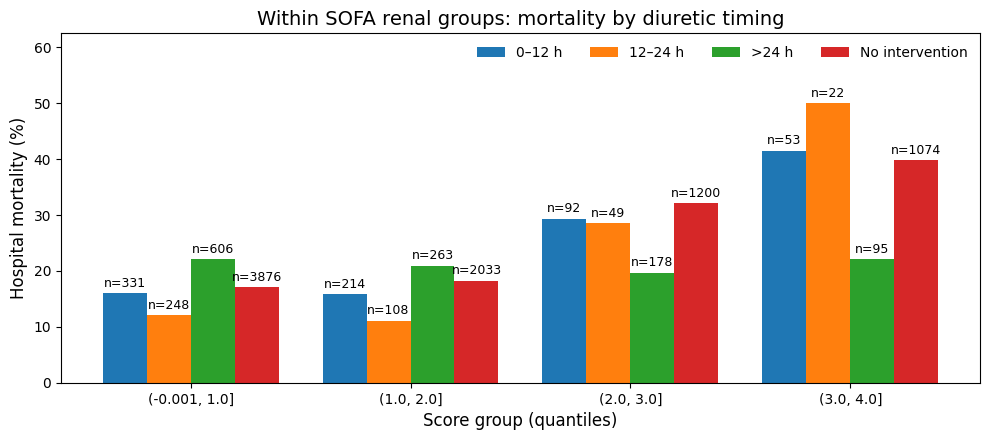

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


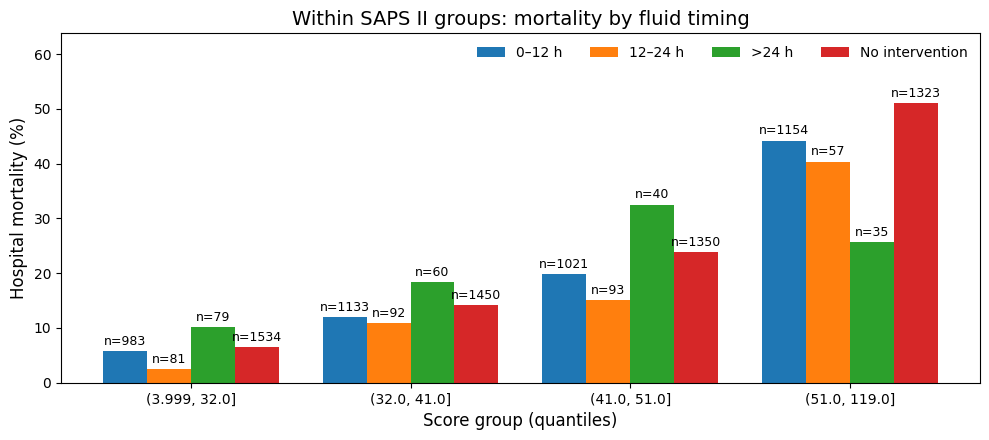

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


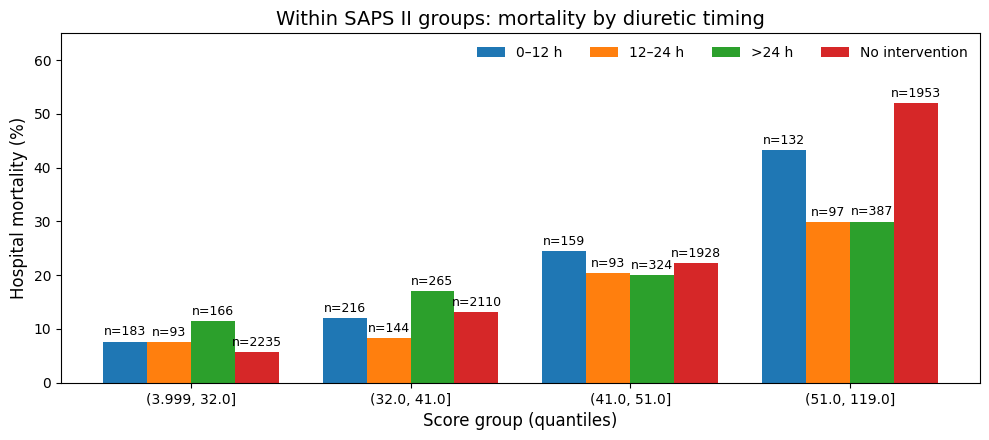

In [80]:
# --- SOFA renal bins: Fluids + Diuretics
stats_renal_fluid = score_group_timing_stats(df4, "sofa_renal_bin", "fluid_timing")
plot_mortality_by_timing_within_score_bins(
    stats_renal_fluid,
    "sofa_renal_bin",
    "fluid_timing",
    "Within SOFA renal groups: mortality by fluid timing"
); plt.show()

stats_renal_diur = score_group_timing_stats(df4, "sofa_renal_bin", "diuretic_timing")
plot_mortality_by_timing_within_score_bins(
    stats_renal_diur,
    "sofa_renal_bin",
    "diuretic_timing",
    "Within SOFA renal groups: mortality by diuretic timing"
); plt.show()


# --- SAPS II bins: Fluids + Diuretics
stats_saps_fluid = score_group_timing_stats(df4, "sapsii_bin", "fluid_timing")
plot_mortality_by_timing_within_score_bins(
    stats_saps_fluid,
    "sapsii_bin",
    "fluid_timing",
    "Within SAPS II groups: mortality by fluid timing"
); plt.show()

stats_saps_diur = score_group_timing_stats(df4, "sapsii_bin", "diuretic_timing")
plot_mortality_by_timing_within_score_bins(
    stats_saps_diur,
    "sapsii_bin",
    "diuretic_timing",
    "Within SAPS II groups: mortality by diuretic timing"
); plt.show()
